# $\mathrm{H_2O_2}$

In [1]:
using Plots, MLPlotRecipes 
using HDF5 
using Tables
using MLJ, MLJGaussianProcesses

In [2]:
h5_path = "../../data/photolysis_data.h5" 
isfile(h5_path)

true

In [3]:
h5 = h5open(h5_path, "r");

In [4]:
cross_sections = h5["cross-sections"]

"H2O2" ∈ keys(cross_sections)

H2O2_data = cross_sections["H2O2"]

📂 HDF5.Group: /cross-sections/H2O2 (file: ../../data/photolysis_data.h5)
├─ 🏷️ T1_units
├─ 🏷️ T2_units
├─ 🏷️ category
├─ 🏷️ formula
├─ 🏷️ sub-category
├─ 🏷️ Δσ_units
├─ 🏷️ λ_units
├─ 🏷️ σ_units
├─ 🔢 T1
├─ 🔢 T2
├─ 🔢 source_idx
├─ 📂 source_info
│  ├─ 📂 1
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 10
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 11
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 12
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 13
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 14
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 15
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi
│  │  └─ 🏷️ download_url
│  ├─ 📂 16
│  │  ├─ 🏷️ author(year)
│  │  ├─ 🏷️ comments
│  │  ├─ 🏷️ doi

In [5]:
λs = read(H2O2_data, "λ")
σs = read(H2O2_data, "σ")
T1s = read(H2O2_data, "T1")
T2s = read(H2O2_data, "T2")
source_idx = read(H2O2_data, "source_idx")



T_units = read_attribute(H2O2_data, "T1_units")
category= read_attribute(H2O2_data, "category")
formula= read_attribute(H2O2_data, "formula")
λ_units = read_attribute(H2O2_data, "λ_units")
σ_units = read_attribute(H2O2_data, "σ_units")

println(T_units)
println(category)
println(formula)
println(λ_units)
println(σ_units)

close(h5)

K
Peroxides
H2O2
nm
cm^2


In [6]:
println(size(λs))
println(size(T1s))
println(size(σs))

(1164,)
(30,)
(1164,)


In [7]:
using DataFrames

In [8]:
function generate_data_table(λs, σs, T1s, T2s, source_idx; σ_lb=1e-25, σ_ub=1.0, T_lb=290.0, T_ub=305.0, λ_lb=200.0, λ_ub=1100.0)
    Tout = [T1s[source_idx[i]] for i ∈ 1:size(source_idx, 1)]
    
    # we want T2 to be NaN
    idx = [ i for i  ∈ 1:size(source_idx,1) if isnan(T2s[source_idx[i]])]
    λout = λs[idx]
    σout = σs[idx]
    Tout = Tout[idx]
    source_out = source_idx[idx]

    # we want T between T_lb and T_ub
    idx2 = [i for i ∈ 1:size(λout,1) if (T_lb ≤ Tout[i] && Tout[i] ≤ T_ub)]
    λout = λout[idx2]
    σout = σout[idx2]
    Tout = Tout[idx2]
    source_out = source_out[idx2]

    # we want σ to not be NaN and greater than 0.
    idx3 = [i for i ∈ 1:size(σout,1) if !isnan(σout[i]) && (σout[i] > σ_lb) && (σout[i] ≤ σ_ub)]
    λout = λout[idx3]
    σout = σout[idx3]
    Tout = Tout[idx3]
    source_out = source_out[idx3]

    # we want λ to be between λ_lb and λ_ub
    idx4 = [i for i ∈ 1:size(λout,1) if (λ_lb ≤ λout[i] && λout[i] ≤ λ_ub)]
    λout = λout[idx4]
    σout = σout[idx4]
    Tout = Tout[idx4]
    source_out = source_out[idx4]
   
    # idxs = [i for i ∈ 1:size(source_idx, 1) if (T_lb < Temps[i] && Temps[i] < T_ub) && (!isnan(σs[i])) && (σs[i] ≥ 0.0) && (λ_lb ≤ λs[i] && λs[i] ≤ λ_ub) && isnan(T2s[source_idx[i]])]

    # 5. Create table with data containing the good values
    #data_table = Tables.columntable((; λ=λout, σ=σout, T=Tout, source_id=source_out))
    df =  DataFrame(λ=λout, σ=σout, T=Tout, source_id=source_out)
    return df
end


df = generate_data_table(λs, σs, T1s, T2s, source_idx)
println(nrow(df))
describe(df)

370


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,267.227,200.0,260.0,400.0,0,Float64
2,σ,1.24797e-19,2.5e-24,5.565e-20,5.47e-19,0,Float64
3,T,297.984,295.0,298.0,300.0,0,Float64
4,source_id,12.3324,1,11.0,29,0,Int64


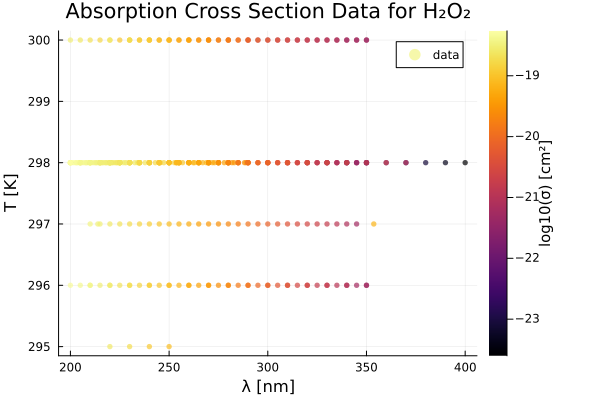

In [9]:
p = scatter(
    df.λ,
    df.T,
    zcolor=log10.(df.σ),
    ms=3,
    msw=0, 
    xlabel="λ [$(λ_units)]",
    ylabel="T [$(T_units)]",
    label="data", 
    alpha=0.7, 
    rightmargin=10Plots.mm,
    colorbar_title="log10(σ) [cm²]",
    title="Absorption Cross Section Data for H₂O₂",
)


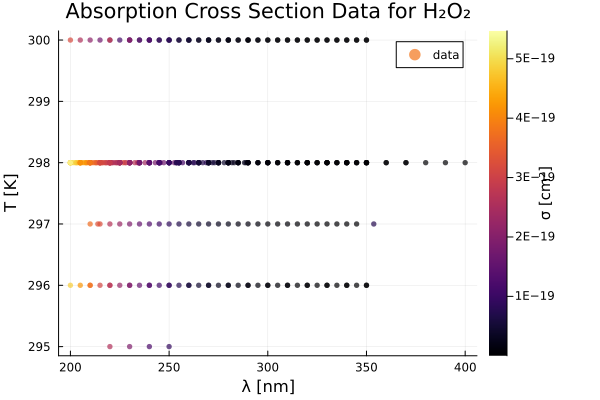

In [10]:
p = scatter(
    df.λ,
    df.T,
    zcolor=df.σ,
    ms=3,
    msw=0, 
    xlabel="λ [$(λ_units)]",
    ylabel="T [$(T_units)]",
    label="data", 
    alpha=0.7, 
    rightmargin=10Plots.mm,
    colorbar_title="σ [cm²]",
    title="Absorption Cross Section Data for H₂O₂",
)


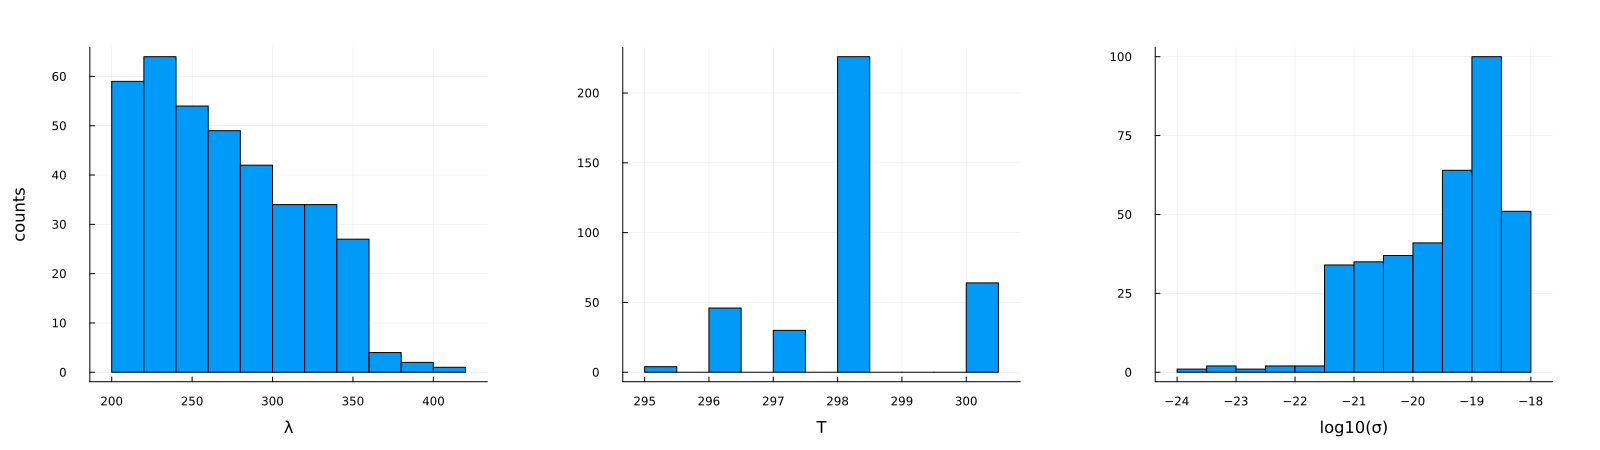

In [11]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450))

We can now thik of this as providing our training data. The goal is to learn a function $f:(\lambda, T) \mapsto \sigma$. Our model of choice will be to use a gaussian process.

First let's split up the data into training and testing pairs. 

::: {.callout-important} 

We should think carefully about how to do this. The most important information is probably in regions where there is rapid changes. We can also examine fitting $\log(\sigma)$ if $\sigma$ alone is to sharply peaked...

:::

In [22]:
n = nrow(df)
train_frac = 0.1

idxs = shuffle(1:n)
ntrain = round(Int, (1.0 - train_frac)*n)

idx_train = idxs[1:ntrain]
idx_test = idxs[ntrain+1:end]


df_train = df[idx_train, :]
df_test = df[idx_test, :]


Row,λ,σ,T,source_id
,Float64,Float64,Float64,Int64
1,220.0,2.58e-19,298.0,6
2,335.0,1.0e-21,298.0,8
3,340.0,8.2e-22,297.0,28
4,255.0,2.46e-20,300.0,7
5,235.0,1.56e-19,297.0,28
6,220.0,2.45e-19,298.0,13
7,345.0,5.0e-22,298.0,8
8,330.0,1.3e-21,296.0,11
9,340.0,8.0e-22,300.0,7


In [23]:
Xtrain = df_train[!, [:λ, :T]];
ytrain = log10.(df_train[!, :σ]);

Xtest = df_test[!, [:λ, :T]];
ytest = log10.(df_test[!, :σ]);

In [53]:
using Pkg
Pkg.add("ParameterHandling")

   Resolving package versions...
    Updating `~/gitrepos/ActivePure/Photolysis.jl/mcm/Project.toml`
  [2412ca09] + ParameterHandling v0.4.6
  No Changes to `~/gitrepos/ActivePure/Photolysis.jl/mcm/Manifest.toml`


In [68]:
using KernelFunctions
using ParameterHandling

kernel(θ) = θ.σ₁²*(SqExponentialKernel() ∘ ScaleTransform(1/(2(θ.ℓ₁)^2))) + θ.σ₂²*(Matern32Kernel() ∘ ScaleTransform(1/(2(θ.ℓ₂)^2)))
θ_init = (;σ₁²=positive(0.1), ℓ₁=positive(0.1), σ₂²=positive(0.1), ℓ₂=positive(0.1),)
gpr = GPR(
    k = kernel,
    θ_init = θ_init, 
    σ²=1e-7
)
# mach = machine(gpr, Xtrain, ytrain) |> fit!
mach = machine(gpr, df[!, [:λ, :T]], log10.(df.σ)) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0     5.520506e+07     4.683357e+07
 * time: 0.00015687942504882812
     1     8.397008e+04     1.850000e+02
 * time: 0.1980438232421875
     2     2.910224e+03     8.683632e+06
 * time: 0.7028379440307617
     3     2.339622e+03     2.052704e+13
 * time: 2.0466439723968506
     4     2.284220e+03     1.830463e+02
 * time: 2.2037007808685303
     5     1.831759e+03     1.594123e+02
 * time: 2.2866809368133545
     6     1.672186e+03     1.028704e+02
 * time: 2.4727489948272705
     7     1.640279e+03     6.596509e+01
 * time: 2.5251169204711914
     8     1.624784e+03     8.922078e+00
 * time: 2.5702309608459473
     9     1.624559e+03     3.020414e-01
 * time: 2.632138967514038
    10     1.624521e+03     4.003218e+00
 * time: 2.754595994949341
    11     1.559835e+03     1.059581e+02
 * time: 2.8942248821258545
    12     1.558517e+03     1.021434e+02
 * time: 3.015133857727051
    13     1.312760e+03     9.561306e+01
 * time: 3.111194849

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @412 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @762 ⏎ AbstractVector{Continuous}


In [69]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [0.08517875349265944, -1.2829398398521916e11, 5.942946238151963, 40.71001341650538, -2.8475008475089973],
 minimum = 314.9541966975367,
 iterations = 33,
 converged = true,)

In [70]:
y_pred_train = predict_mean(mach, Xtrain)
y_pred_test = predict_mean(mach, Xtest)


py_train = predict(mach, Xtrain)
py_test = predict(mach, Xtest)

py_train[1]

Distributions.Normal{Float64}(μ=-21.399818476559005, σ=0.10712744012232024)

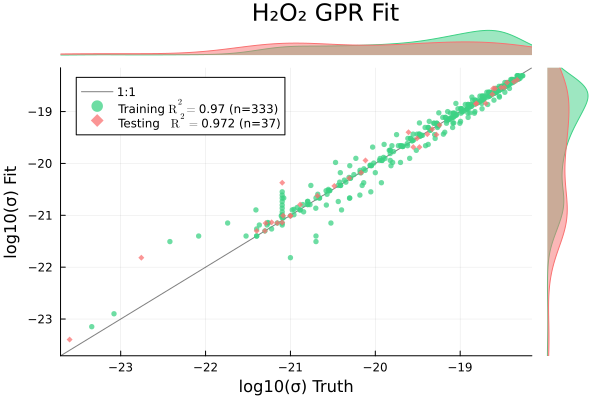

In [71]:
scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="H₂O₂ GPR Fit"
)

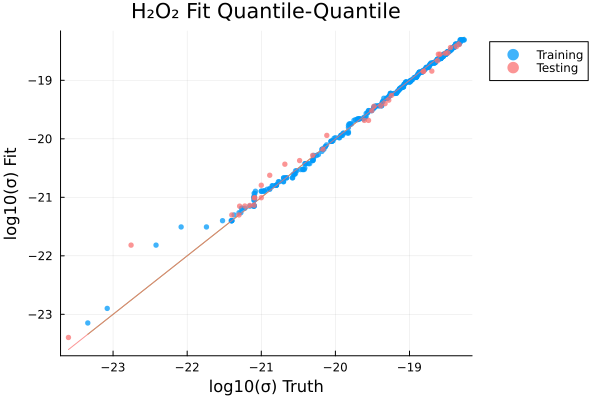

In [72]:
quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="H₂O₂ Fit Quantile-Quantile"
)

Now let's plot the resulting function on a grid: 

In [78]:
λ₁ = minimum(df.λ)
λ₂ = maximum(df.λ)
T₁ = minimum(df.T)
T₂ = maximum(df.T)

Δλ = λ₂ - λ₁
ΔT = T₂ - T₁

fudge_fac = 0.1
λ₁ = λ₁ - fudge_fac*Δλ
λ₂ = λ₂ + fudge_fac*Δλ
T₁ = T₁ - fudge_fac*ΔT
T₂ = T₂ + fudge_fac*ΔT


λs = range(λ₁, λ₂, length=200)
Ts = range(T₁, T₂, length=50)

# resulting shape should be reshaped to 500 by 50
λ_grid = [λ for λ∈λs, T∈Ts]
T_grid = [T for λ∈λs, T∈Ts]
df_grid = DataFrame(λ=vcat(λ_grid...), T=vcat(T_grid...))
σ_grid = reshape(predict_mean(mach, df_grid),(200,50))

heatmap(λs, Ts, σ_grid)

scatter!(
    df.λ,
    df.T,
    zcolor=log10.(df.σ),
    ms=4,
    label="data", 
    rightmargin=10Plots.mm,
    colorbar_title="σ [cm²]",
)


298.0

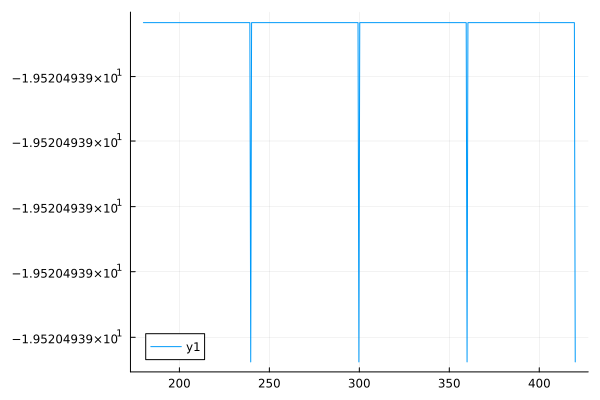

In [80]:
λs = range(λ₁, λ₂, length=500)
Ts = [298.0 for _ ∈ 1:500]
df_pred = DataFrame(λ=λs, T=Ts)
σ_preds = predict_mean(mach, df_pred)

plot(λs, σ_preds)

In [81]:
function make_training_data(n, ν)
    xs = reshape(collect(range(0.0, stop=1.0, length=500)), (1,500))

    y(x) = (exp(-x/(0.5)^2) * sin(2π*ν*x)) + (0.3)^2*(rand()-0.5)
    ytruth(x) = exp(-x/(0.5)^2) * sin(2π*ν*x)

    X = Tables.table(rand(1,n)', header=[:x])
    Xtrue = Tables.table(xs', header=[:x])

    y = y.(X.x)
    ytrue = ytruth.(Xtrue.x)

    return X, y, Xtrue, ytrue
end

X, y, Xtrue, ytrue = make_training_data(50, 10)

(Tables.MatrixTable{LinearAlgebra.Adjoint{Float64, Matrix{Float64}}} with 50 rows, 1 columns, and schema:
 :x  Float64, [-0.11910037399566864, 0.01220942201251572, -0.010091656163291975, 0.02066646335009669, -0.011549536452583477, 0.8137673436519305, -0.039571239673889064, -0.011172731423395085, -0.144878198731118, -0.12315261399469685  …  -0.033534805230887144, 0.14887469603148903, 0.890109273286779, -0.04974330747314241, 0.2781718602943487, -0.042666066500645396, -0.12454136396033408, -0.06221610591174015, 0.1735472693012275, 0.0501742130486802], Tables.MatrixTable{LinearAlgebra.Adjoint{Float64, Matrix{Float64}}} with 500 rows, 1 columns, and schema:
 :x  Float64, [0.0, 0.12458042096548765, 0.24521471376453977, 0.3600631014574817, 0.46740631751315176, 0.5656708039301793, 0.6534512106157103, 0.7295298841027695, 0.7928930861297541, 0.8427437383060459  …  -0.017831231548023147, -0.016509647442768692, -0.01494870660243864, -0.013176833587402128, -0.011225327522356849, -0.0091278227565441

In [82]:
kernel(θ) = θ.σ₁²*(SqExponentialKernel() ∘ ScaleTransform(1/(2(θ.ℓ₁)^2))) + θ.σ₂²*(Matern32Kernel() ∘ ScaleTransform(1/(2(θ.ℓ₂)^2)))
θ_init = (;σ₁²=positive(0.1), ℓ₁=positive(0.1), σ₂²=positive(0.1), ℓ₂=positive(0.1),)
gpr = GPR(
    k = kernel,
    θ_init = θ_init, 
    σ²=1e-7
)
# mach = machine(gpr, Xtrain, ytrain) |> fit!
mach = machine(gpr, X, y) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0     6.176849e+02     3.294959e+03
 * time: 0.0001609325408935547
     1     4.245610e+02     2.500000e+01
 * time: 0.01802802085876465
     2     1.536238e-01     9.276824e+00
 * time: 0.023598909378051758
     3    -1.838432e+00     1.642444e+01
 * time: 0.028696060180664062
     4    -2.222085e+00     3.646697e+00
 * time: 0.031058073043823242
     5    -2.409770e+00     1.895024e+00
 * time: 0.03342390060424805
     6    -2.424902e+00     4.591384e-02
 * time: 0.03683209419250488
     7    -2.424945e+00     6.948281e-03
 * time: 0.04055190086364746
     8    -2.424955e+00     4.642882e-02
 * time: 0.04716300964355469
     9    -3.911795e+00     1.691929e+01
 * time: 0.06146502494812012
    10    -3.911854e+00     1.693188e+01
 * time: 0.06484293937683105
    11    -2.544498e+01     1.811944e+01
 * time: 0.07523202896118164
    12    -2.773278e+01     1.382678e+01
 * time: 0.08808112144470215
    13    -3.026212e+01     4.678491e+00
 * 

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @492 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @084 ⏎ AbstractVector{Continuous}


In [88]:
y_pred = predict_mean(mach, Xtrue)

500-element Vector{Float64}:
  0.5608180743428964
  0.6071206663803306
  0.6529973819201168
  0.6977092492488189
  0.7404547349060291
  0.7803823497474104
  0.8166060889345779
  0.8482234990255315
  0.8743360494648164
  0.8940713721610013
  0.9066068265312588
  0.9111937534571365
  0.9071817048894731
  ⋮
 -0.06438038355570742
 -0.06776164321695946
 -0.07041055912915144
 -0.0723032111728047
 -0.07343523548509083
 -0.07382060128312681
 -0.07348987474542858
 -0.07248807840635572
 -0.0708722612638966
 -0.06870889576551893
 -0.06607121353515381
 -0.0630365828885893

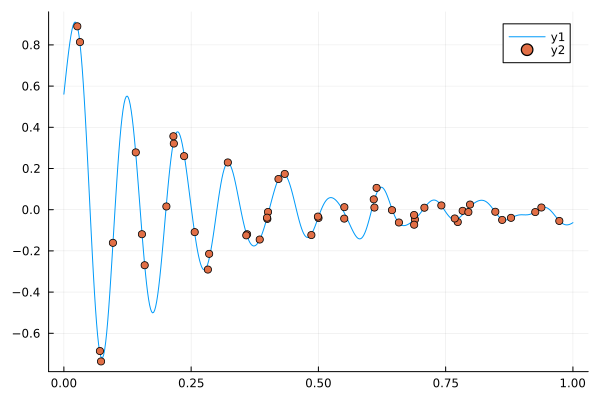

In [89]:
plot(Xtrue.x, y_pred)
scatter!(X.x, y)

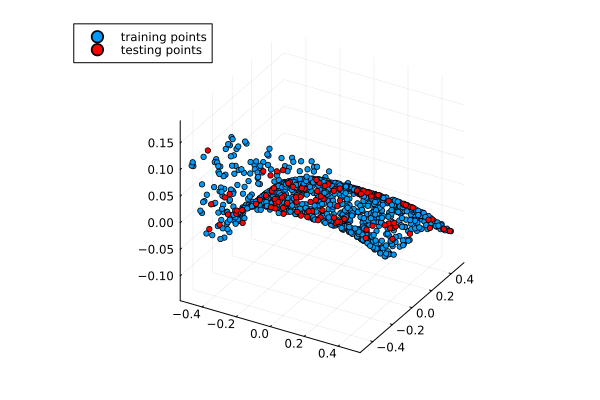

In [90]:
n=1000
xs = (rand(n,2) .- 0.5)
x₁ = xs[:,1]
x₂ = xs[:,2]
y = x₁.^5 .+ x₂.^4 .- x₁.^4 .- x₂.^3 

Xtrain = Tables.table(xs[1:Int(0.9*n), :], header=[:x₁, :x₂])
Xtest = Tables.table(xs[Int(0.9*n)+1:end, :], header=[:x₁, :x₂])

ytrain = y[1:Int(0.9*n)]
ytest = y[Int(0.9*n)+1:end]

scatter(Xtrain.x₁, Xtrain.x₂, ytrain, ms=3, label="training points")
scatter!(Xtest.x₁, Xtest.x₂, ytest, color=:red, ms=3, label="testing points")

In [92]:
kernel(θ) = θ.σ₁²*(SqExponentialKernel() ∘ ScaleTransform(1/(2(θ.ℓ₁)^2))) + θ.σ₂²*(Matern32Kernel() ∘ ScaleTransform(1/(2(θ.ℓ₂)^2)))
θ_init = (;σ₁²=positive(0.1), ℓ₁=positive(0.1), σ₂²=positive(0.1), ℓ₂=positive(0.1),)
gpr = GPR(
    k = kernel,
    θ_init = θ_init, 
#    σ²=1e-7
)
# mach = machine(gpr, Xtrain, ytrain) |> fit!
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -1.670727e+02     5.199854e+02
 * time: 0.00019097328186035156
     1    -4.734137e+03     1.503170e+03
 * time: 4.420762062072754
     2    -4.840642e+03     9.308025e+02
 * time: 5.104015111923218
     3    -5.098898e+03     8.038598e+02
 * time: 5.796343088150024
     4    -5.346684e+03     3.970594e+02
 * time: 6.482567071914673
     5    -5.896281e+03     1.717814e+03
 * time: 7.4011549949646
     6    -6.727720e+03     9.644671e+02
 * time: 8.08535099029541
     7    -6.864112e+03     4.600626e+01
 * time: 8.542866945266724
     8    -6.886448e+03     4.059468e+02
 * time: 9.247071981430054
     9    -6.898714e+03     7.109971e+01
 * time: 9.94740605354309
    10    -6.906918e+03     2.015111e+02
 * time: 10.866995096206665
    11    -6.913086e+03     1.368285e+02
 * time: 11.548546075820923
    12    -6.950506e+03     2.913849e+02
 * time: 12.473842144012451
    13    -7.001777e+03     4.041452e+02
 * time: 13.156044960021973
  

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @728 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @679 ⏎ AbstractVector{Continuous}


In [93]:
y_pred_train = predict_mean(mach, Xtrain)
y_pred_test = predict_mean(mach, Xtest)

100-element Vector{Float64}:
 -2.8878450393676758e-5
  0.0344734862446785
  0.09831034205853939
 -0.01759042777121067
 -0.06359002739191055
 -0.01516430452466011
  0.0030932649970054626
 -0.0002354402095079422
 -0.014944754540920258
 -0.05883212573826313
 -0.08973219990730286
 -0.00040311552584171295
 -0.01130409725010395
  ⋮
 -1.8864870071411133e-5
  0.0848623551428318
 -0.014372158795595169
  0.001810908317565918
 -0.017009228467941284
 -0.0011161155998706818
 -0.03888287954032421
 -0.020225761458277702
  0.0007748045027256012
  0.0014734435826539993
 -0.04117823205888271
  0.07993144396459684

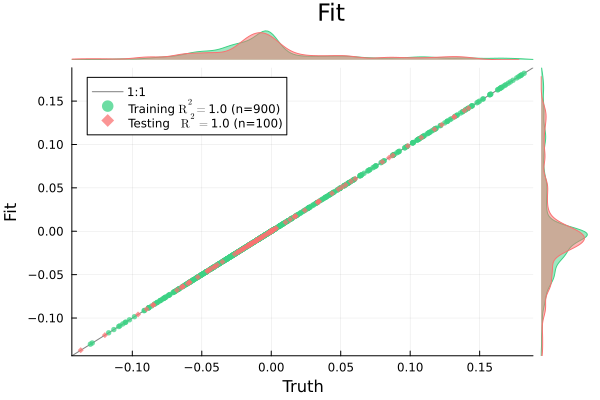

In [95]:
scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Truth",
    ylabel="Fit",
    plot_title="Fit"
)

Okay, so this confirms that my GPR algorithm